# Populating the Spreadsheet

### Workflow:

- refer to Sheet 2 – first, sort by "absent", and pick a **group** from here (group_number_Maho_2009)
- **For each group**, search for it in Sheet 1, and for each language
- add these labels:
	1) coder
	2) glotto_dict
		- add the citation of Doctype=dictionary for each ISO
		- constraints: add only the latest work, plus 75 pages
	3) Gramfinder
		- Does it have a DICTIONARY on grambank?
		- search this by picking the ISO code from sheet one for each of the languages of the group
		- IMP: add the link! if link doesn't exist, then mark as absent
		- QQQ: am i required to make sure the dictionary is accessible?
	4) NC_annotation
		- does the dictionary contain Noun Class Annotation? (mostly as a number)

-

- For now, focus on finding the file url, and appending it to a new column. NC_annotation can be done later

- **glottolog** access can be automated by their python library
- Grambank HTML can be read by **BeautifulSoup**

## 1. Data Loading and setup

In [1]:
# !pip install transliterate
# !pip install beautifulsoup4
# !pip install matplotlib seaborn

In [2]:
# imports

import pandas as pd
import requests
from requests.auth import HTTPBasicAuth
import urllib3
import re
from bs4 import BeautifulSoup
from requests.auth import HTTPBasicAuth
from time import time
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
sheet1_df,sheet2_df = pd.read_csv('data/groups_sheet1.csv'), pd.read_csv('data/reflex_groups_sheet2.csv')

In [70]:
# if columns already exist, then delete

try:
    sheet1_df.drop(['Glotto_dict','Gram_dict'], axis=1, inplace=True)
    
except:
    print("all good")

    
sheet1_df.head()

,Glotto_name,Guthrie_code_Maho_2009,ISO,group_number_Maho_2009,group_name,comment_classification,coder,Gramfinder,NC_annotation
0,Bima (oroko),A11,bdu,A10,Lundu-Balong,NaN,NaN,NaN,NaN
1,Bima (oroko),A12,bdu,A10,Lundu-Balong,NaN,NaN,NaN,NaN
2,Bafaw-Balong,A13,bwt,A10,Lundu-Balong,NaN,NaN,NaN,NaN
3,Bonkeng,A14,bvg,A10,Lundu-Balong,NaN,NaN,NaN,NaN
4,Bareko,A15A,mbo,A10,Lundu-Balong,NaN,NaN,NaN,NaN


In [5]:
# Transliterate the maho groups column from Cyrilic С --> Latin C

sheet1_df['group_number_Maho_2009']= sheet1_df['group_number_Maho_2009'].str.replace('С','C')
sheet2_df['group_number_Maho_2009']= sheet2_df['group_number_Maho_2009'].str.replace('С','C')


In [6]:
# consider only absents
absent_sheet2_df = sheet2_df[sheet2_df['RefLex']=='absent']

In [7]:
absent_sheet2_df.describe()

,group_number_Maho_2009,group_name,RefLex
count,59,54,59
unique,59,53,1
top,A50,Temi,absent
freq,1,2,59


In [8]:
# sorting by group values
sorted_s2_df= absent_sheet2_df.sort_values(by='group_number_Maho_2009', ascending=True)   

In [9]:
s2_groupings_list = sorted_s2_df['group_number_Maho_2009'].tolist()


for maho_group in s2_groupings_list[:5]:
    
    print(f'Maho_Group: {maho_group}')
    curr_lang_list = sheet1_df[sheet1_df['group_number_Maho_2009'] == maho_group]['ISO'].tolist()

    print(curr_lang_list)

    # access gramfinder for each language ISO
    for iso in curr_lang_list:
        if len(str(iso)) == 3:
            print(iso)
            
        else: 
            # add NaN here
            print('NaN')
            pass
    print('\n')

    

Maho_Group: A30
['bvb', 'bnm', 'yko', 'nui', 'bng']
bvb
bnm
yko
nui
bng


Maho_Group: A50
['hij', 'lfa', 'dii', 'ksf', 'ngy']
hij
lfa
dii
ksf
ngy


Maho_Group: A90
['kwu', 'pmm', 'kkj']
kwu
pmm
kkj


Maho_Group: B10
['mye']
mye


Maho_Group: B40
['bwz', 'bbg', 'vum', '-', 'swj', 'snq', 'puu', 'lup']
bwz
bbg
vum
NaN
swj
snq
puu
lup




## 2. Gramfinder HTML through BS4

In [10]:

# This line hides the "InsecureRequestWarning" that will pop up repeatedly
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

URL = 'https://130.60.24.118/gramfinder/p/hhbylanguage.html'
USER = 'harshasunaye'
PASS = 'harshabharatkoti'
response = requests.get(URL, auth=HTTPBasicAuth(USER, PASS), verify=False)
soup = BeautifulSoup(response.content, 'html.parser')


In [11]:

def get_iso_dictionary_data(soup, iso_code):
    # 1. Locate the header for the specific ISO
    anchor = soup.find('a', attrs={'name': iso_code})
    if not anchor:
        return "Not found"

    header = anchor.find_parent('h3')
    table = header.find_next('table')
    if not table:
        return "Not found"

    results = []

    # 2. Iterate through rows in the language's table
    for row in table.find_all('tr'):
        # Find the 'dictionary' label
        dict_label = row.find('a', style="monospace;", string=re.compile(r'dictionary', re.I))
        
        if dict_label:
            # Look for the IMMEDIATE previous sibling tag.
            # Based on your HTML, the PDF links sit inside a <small> tag right before the label.
            prev_tag = dict_label.find_previous_sibling()

            # STRICTURE: Only proceed if the previous tag is <small>
            if prev_tag and prev_tag.name == 'small':
                # Find all links inside this specific <small> tag
                pdf_links = prev_tag.find_all('a', href=True)
                
                for pdf in pdf_links:
                    results.append({
                        'iso': iso_code,
                        'filename': pdf.get_text(strip=True),
                        'href': 'https://130.60.24.118/gramfinder/p/'+pdf['href']
                    })
    
    return results

In [27]:

# these languages: old, bmb have NO href to dict, so it should be marked as no

all_data = []

for iso in ['abb','aaaa','alu','old','bmb','xam','hnh']:
    data = get_iso_dictionary_data(soup, iso)
    if len(data) == 0 or data=="Not found":
        print(f"Not found for iso: {iso}")
    else:
        
        all_data.extend(data)
        for item in data:
            print(f"ISO: {item['iso']} | File: {item['filename']} | Link: {item['href']}")

df = pd.DataFrame(all_data)
df.to_csv('iso_dict_links.csv', index=False)

Not found for iso: abb
Not found for iso: aaaa
ISO: alu | File: geerts_areare1970.pdf | Link: https://130.60.24.118/gramfinder/p/papua/geerts_areare1970.pdf
ISO: alu | File: geerts_areare1970_o.pdf | Link: https://130.60.24.118/gramfinder/p/papua/geerts_areare1970_o.pdf
Not found for iso: old
Not found for iso: bmb
ISO: xam | File: raper_xam-grammatika2022.pdf | Link: https://130.60.24.118/gramfinder/p/africa/raper_xam-grammatika2022.pdf
ISO: xam | File: raper_xam-grammatika2022_o.pdf | Link: https://130.60.24.118/gramfinder/p/africa/raper_xam-grammatika2022_o.pdf
ISO: hnh | File: fehn_anikhwe-dictionary2024.pdf | Link: https://130.60.24.118/gramfinder/p/africa/fehn_anikhwe-dictionary2024.pdf


In [13]:
def main_cycle(sheet1_df, s2_groupings_list):
    # This will store small dataframes instead of dictionaries
    df_list = []

    for maho_group in s2_groupings_list:
        print(f'Maho_Group: {maho_group}')
        
        # Get the list of ISOs for this group
        curr_lang_list = sheet1_df[sheet1_df['group_number_Maho_2009'] == maho_group]['ISO'].tolist()
        print(curr_lang_list)
    
        for iso in curr_lang_list:
            
            data = get_iso_dictionary_data(soup, iso)
            
            # Case 1: No data found - Create a single-row "NaN" DataFrame
            if len(data) == 0 or data == "Not found":
                print(f"Not found for iso: {iso}")
                empty_row = pd.DataFrame([{
                    'iso': iso,
                    'filename': 'NaN',
                    'href': 'NaN'
                }])
                df_list.append(empty_row)
                
            # Case 2: Data found - Convert the result (list of dicts) to a DataFrame
            else:
                new_rows = pd.DataFrame(data)
                df_list.append(new_rows)
                
                # Feedback for user
                for item in data:
                    print(f"ISO: {item.get('iso')} | File: {item.get('filename')} | Link: {item.get('href')}")

    # Combine all small dataframes into one single result
    # 1. Combine all data
    raw_df = pd.concat(df_list, ignore_index=True)

    # 2. Group by ISO and aggregate columns into lists
    # This merges all filenames/hrefs for the same ISO into a single row
    grouped_df = raw_df.groupby('iso').agg({
        'filename': list,
        'href': list
    }).reset_index()
    
    return grouped_df

def fix_href_links(df):
    def clean_cell(val):
        # 1. If it's already a list, join it
        if isinstance(val, list):
            return ",\n".join(val)
        
        # 2. If it's a string that looks like a list "['a', 'b']", convert it first
        if isinstance(val, str) and val.startswith('['):
            try:
                actual_list = ast.literal_eval(val)
                return ",\n".join(actual_list)
            except:
                return val
        
        return val

    df['href'] = df['href'].apply(clean_cell)
    return df
    



In [14]:
# Running the cycle

start_time = time()

final_df = main_cycle(sheet1_df, s2_groupings_list)

final_final = fix_href_links(final_df)

end_time = time()

Maho_Group: A30
['bvb', 'bnm', 'yko', 'nui', 'bng']
ISO: bvb | File: bolekia_bubi2009_o.pdf | Link: https://130.60.24.118/gramfinder/p/africa/bolekia_bubi2009_o.pdf
ISO: bvb | File: bolekia_bubi2009.pdf | Link: https://130.60.24.118/gramfinder/p/africa/bolekia_bubi2009.pdf
Not found for iso: bnm
Not found for iso: yko
Not found for iso: nui
ISO: bng | File: good_dictionary-benga1879_o.pdf | Link: https://130.60.24.118/gramfinder/p/africa/good_dictionary-benga1879_o.pdf
ISO: bng | File: good_dictionary-benga1879.pdf | Link: https://130.60.24.118/gramfinder/p/africa/good_dictionary-benga1879.pdf
Maho_Group: A50
['hij', 'lfa', 'dii', 'ksf', 'ngy']
Not found for iso: hij
Not found for iso: lfa
Not found for iso: dii
Not found for iso: ksf
Not found for iso: ngy
Maho_Group: A90
['kwu', 'pmm', 'kkj']
Not found for iso: kwu
Not found for iso: pmm
Not found for iso: kkj
Maho_Group: B10
['mye']
ISO: mye | File: delorme_pongoue1877.pdf | Link: https://130.60.24.118/gramfinder/p/africa/delorme_po

In [15]:
# measure time taken
print(f'Took {((end_time - start_time)/60):2f} min')

Took 3.162809 min


In [20]:
# delete special cases
# final_final = final_final[final_final['iso'].map(len) < 4]

# final_final.drop(index=final_final.index[0], axis=0, inplace=True)
final_final.drop('filename', axis=1, inplace=True)

In [22]:
final_final[final_final['href'] != 'NaN']

,iso,href
7,agh,https://130.60.24.118/gramfinder/p/africa/gera...
11,axk,https://130.60.24.118/gramfinder/p/africa/thom...
14,bdp,https://130.60.24.118/gramfinder/p/africa/abe_...
15,bem,https://130.60.24.118/gramfinder/p/africa/kaso...
30,bng,https://130.60.24.118/gramfinder/p/africa/good...
...,...,...
303,umb,https://130.60.24.118/gramfinder/p/africa/guen...
305,ven,https://130.60.24.118/gramfinder/p/africa/tshi...
319,xho,https://130.60.24.118/gramfinder/p/africa/bach...
330,ziw,https://130.60.24.118/gramfinder/p/africa/dayl...


In [24]:
# match column name with old data
final_final.rename(columns={'iso': 'ISO'}, inplace=True)

In [26]:
# merge Sheet 1 with the dictionary details
merged_final = pd.merge(sheet1_df, final_final, on='ISO', how='left')

merged_final.to_csv('iso_with_dicts.csv', index=False)

### Visualise results

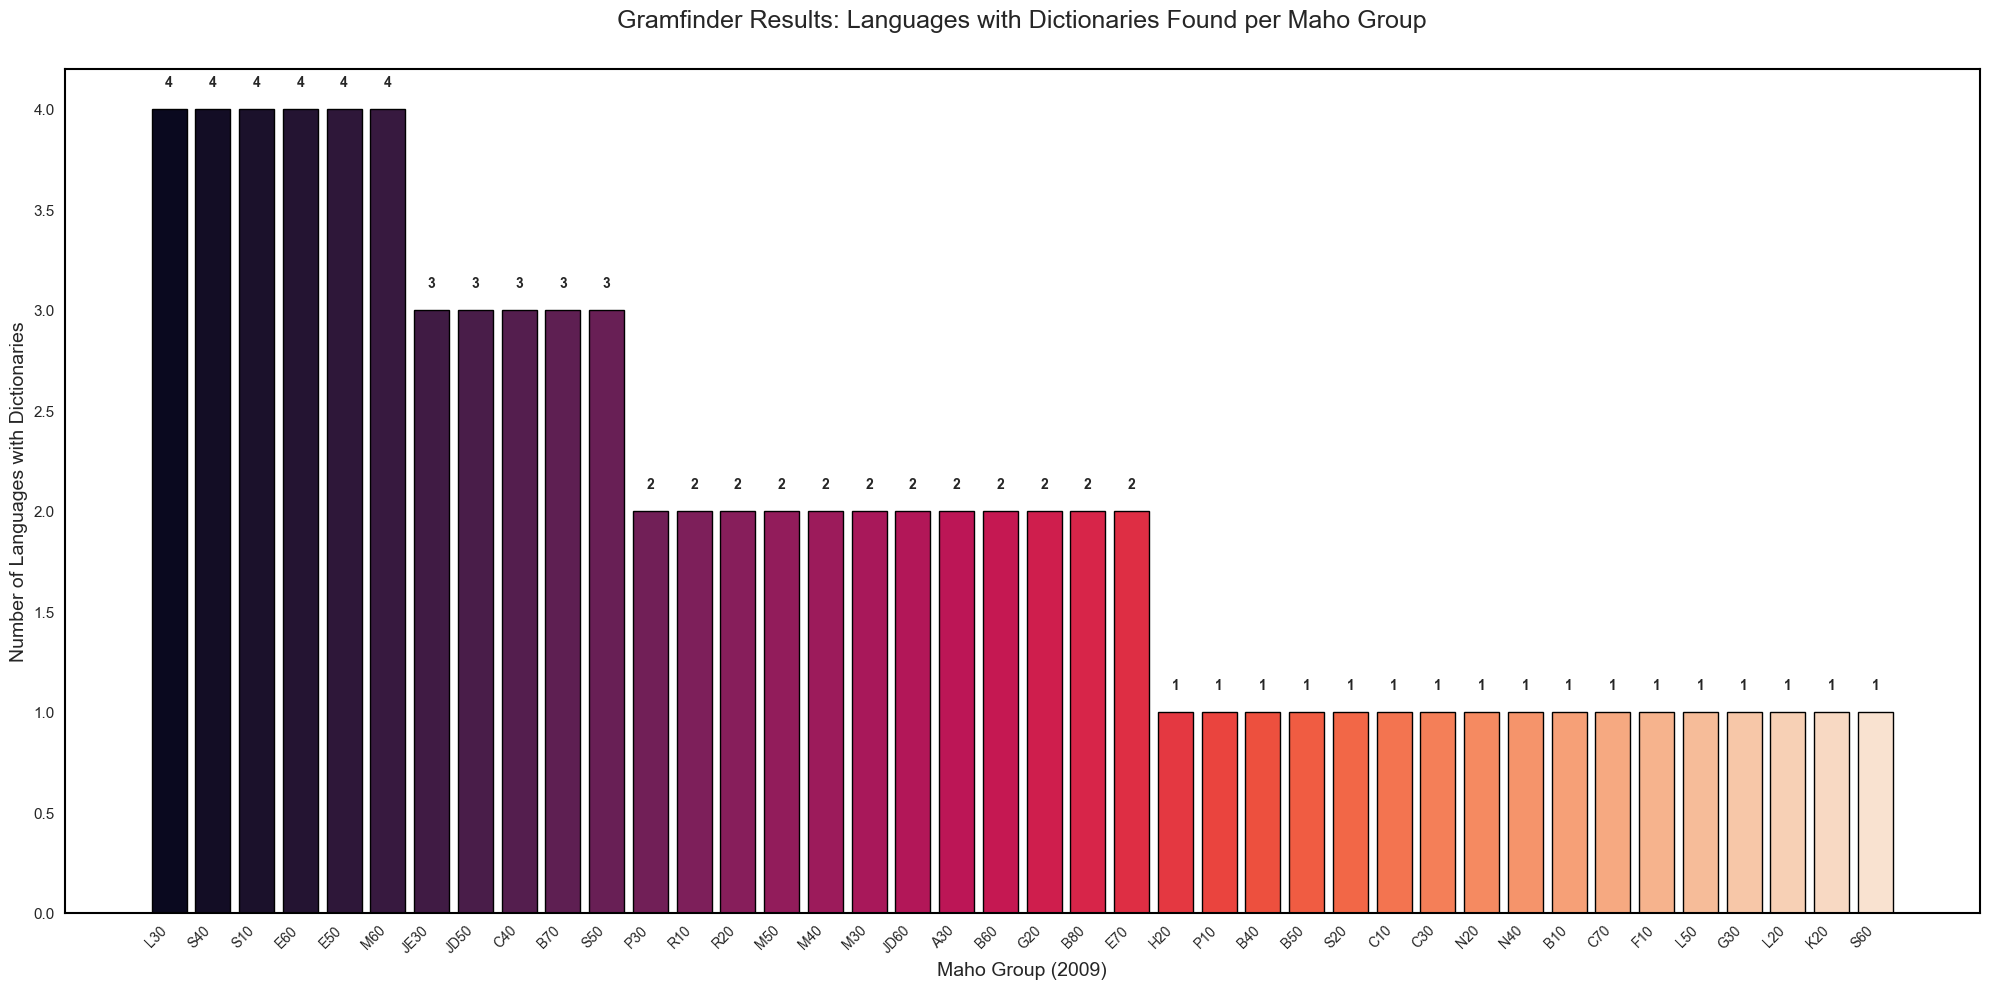

In [69]:

found_data_df = final_final[final_final['href'] != 'NaN'].copy()

# 1. Create a mapping of ISO to its Group from the original sheet
iso_to_group = sheet1_df.set_index('ISO')['group_number_Maho_2009'].to_dict()

# 3. Map the Group back to the found results
found_data_df['group'] = found_data_df['ISO'].map(iso_to_group)

# 1. Prepare data
# Sorting descending for a cleaner vertical "waterfall" look
group_counts = found_data_df.groupby('group')['ISO'].nunique().sort_values(ascending=False)

# 2. Adjust Figure size: Increased width (20), reduced height (10)
plt.figure(figsize=(20, 10)) 
sns.set_style("white") # Using 'white' with solid spines for "solid corners"

# 3. Plot - Vertical Bars
# Note: Use plt.bar for more control over "solid" edges
x_labels = group_counts.index.astype(str)
y_values = group_counts.values
colors = sns.color_palette("rocket", len(group_counts))

bars = plt.bar(x_labels, y_values, color=colors, edgecolor='black', linewidth=1)

# 4. Add data labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        height + 0.1, 
        f'{int(height)}', 
        ha='center', 
        va='bottom', 
        fontsize=10, 
        fontweight='bold'
    )

# 5. Formatting the "Solid" look
ax = plt.gca()
# Ensure the axis spines are solid and visible
for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1.5)

# 6. Labels and Title
plt.xticks(rotation=45, ha='right', fontsize=10) # Rotate to fit more on X-axis
plt.yticks(fontsize=11)
plt.title('Gramfinder Results: Languages with Dictionaries Found per Maho Group', fontsize=18, pad=30)
plt.xlabel('Maho Group (2009)', fontsize=14)
plt.ylabel('Number of Languages with Dictionaries', fontsize=14)

# 7. Final Polish
plt.tight_layout()
plt.savefig('found_dicts_per_group.png')
plt.show()

In [62]:
found_data_df.describe()

,ISO,href,group
count,80,80,80
unique,80,77,40
top,agh,https://130.60.24.118/gramfinder/p/africa/torr...,S40
freq,1,3,4


In [61]:
found_data_df[found_data_df.duplicated(subset=['href'], keep=False)].to_csv('inspect_dups.csv', index= False)

## 3. Glottolog

- Using the latest glottolog (v5.2.1) bibliography from: 
https://github.com/glottolog/glottolog-cldf/blob/master/cldf/sources.bib.zip

**How to use IDs to lookup Glottolog:**

- This function returns the reference ID and the page count. Simply input the reference ID into "any field" box at this page: https://glottolog.org/langdoc


Using this library for parsing bib file:

https://pypi.org/project/biblib/

guide: http://wgserve.de/biblib/tutorial.html

In [45]:
# using regex string matching instead of biblib

def build_iso_lookup(bib_path):
    """
    Scans a massive .bib file line-by-line to collect IDs and Page counts.
    Returns: { 'iso': {123: '302', 456: 'NaN'} }
    """
    iso_map = {}
    
    # Regex patterns
    id_pattern = re.compile(r'^@\w+\s*\{\s*([^,]+)', re.IGNORECASE)
    iso_pattern = re.compile(r'\[([a-z]{3})\]', re.IGNORECASE)
    pages_pattern = re.compile(r'pages\s*=\s*\{([^}]+)\}', re.IGNORECASE)
    
    with open(bib_path, 'r', encoding='utf-8', errors='ignore') as f:
        current_entry_id = None
        is_dictionary = False
        current_iso = None
        current_pages = "NaN"
        
        for line in f:
            line = line.strip()
            
            # 1. Detect start of a new entry
            if line.startswith('@'):
                # Save previous entry if it met criteria
                if current_entry_id and is_dictionary and current_iso:
                    # Initialize sub-dictionary if not exists, then add entry
                    if current_iso not in iso_map:
                        iso_map[current_iso] = {}
                    
                    try:
                        # Store ID as integer key and pages as string value
                        iso_map[current_iso][int(current_entry_id)] = current_pages
                    except ValueError:
                        # Handle cases where the ID in bibtex isn't a pure number
                        pass
                
                # Reset for new entry
                match_id = id_pattern.search(line)
                current_entry_id = match_id.group(1) if match_id else None
                is_dictionary = False
                current_iso = None
                current_pages = "NaN"
                continue
            
            # 2. Extract Data from lines
            if 'hhtype' in line and 'dictionary' in line.lower():
                is_dictionary = True
                
            if 'lgcode' in line:
                match_iso = iso_pattern.search(line)
                if match_iso:
                    current_iso = match_iso.group(1).lower()

            if 'pages' in line:
                match_pages = pages_pattern.search(line)
                if match_pages:
                    current_pages = match_pages.group(1)

        # Final cleanup for the last entry in the file
        if current_entry_id and is_dictionary and current_iso:
            if current_iso not in iso_map:
                iso_map[current_iso] = {}
            try:
                iso_map[current_iso][int(current_entry_id)] = current_pages
            except ValueError:
                pass
            
    return iso_map

# Execution
iso_lookup_map = build_iso_lookup('sources.bib')

In [39]:
len(iso_lookup_map) # filtering only dictionaries

2874

In [46]:
# using test list with some incorrect iso values

my_iso_list = ['puu','yon', 'ifm', 'diz','aaaaa','alu','old','bmb','xam','hnh']

# returns a list of dictionaries for the given iso
temp_dict = {iso: iso_lookup_map.get(iso.lower(), ["NaN"]) for iso in my_iso_list}

{'puu': {322442: '284',
  40715: 'NaN',
  92116: 'NaN',
  86804: '177',
  27050: 'NaN',
  12265: '193-245'},
 'yon': ['NaN'],
 'ifm': {49994: 'iv+346'},
 'diz': {116454: '240', 106521: '398+422+246', 471497: 'xxxi+240'},
 'aaaaa': ['NaN'],
 'alu': {58868: '185+6'},
 'old': {67228: 'NaN', 49520: 'NaN', 407861: 'iv+89'},
 'bmb': {588129: '243'},
 'xam': {697843: '188', 697844: 'xvi+555'},
 'hnh': {701928: '105'}}

In [54]:
glotto_dicts_df = pd.DataFrame((temp_dict.items()), columns=['iso','glotto_dict'])
glotto_dicts_df['glotto_dict'][0]

{322442: '284',
 40715: 'NaN',
 92116: 'NaN',
 86804: '177',
 27050: 'NaN',
 12265: '193-245'}

In [57]:
# running on entire sheet1

def main_cycle_glottolog(sheet1_df, s2_groupings_list, iso_lookup_map):
    # This will store small dataframes instead of dictionaries
    df_list = []

    for maho_group in s2_groupings_list:
        
        # Get the list of ISOs for this group
        curr_lang_list = sheet1_df[sheet1_df['group_number_Maho_2009'] == maho_group]['ISO'].tolist()

        for iso in curr_lang_list:
            
            if len(iso) != 3:
                temp_dict = {iso: "NaN"}
            else:
                temp_dict = {iso: iso_lookup_map.get(iso.lower(), "NaN")}
        
            df_list.append(pd.DataFrame((temp_dict.items()), columns=['iso','glotto_dict']))
            
    # Combine all small dataframes into one single result
    # 1. Combine all data
    raw_df = pd.concat(df_list, ignore_index=True)
    
    # 2. Group by ISO and aggregate columns into lists
    # This merges all filenames/hrefs for the same ISO into a single row

    
    return raw_df

In [73]:
glotto_dicts_df = main_cycle_glottolog(sheet1_df, s2_groupings_list, iso_lookup_map)

In [74]:
glotto_dicts_df.head(5)

,iso,glotto_dict
0,bvb,"{90861: '342', 600186: 'NaN', 320956: '544', 8..."
1,bnm,{701640: 'NaN'}
2,yko,NaN
3,nui,"{90241: '541', 304678: '541'}"
4,bng,"{81296: 'NaN', 8514: '171'}"


In [75]:
# match column name with old data
glotto_dicts_df.rename(columns={'iso': 'ISO'}, inplace=True)

In [77]:
# merge Sheet 1 with the dictionary details
glotto_dicts_df_merged = pd.merge(sheet1_df, glotto_dicts_df, on='ISO', how='left')

glotto_dicts_df_merged.to_csv('glotto_dict_df.csv', index=False)

In [78]:
glotto_dicts_df_merged.head()

,Glotto_name,Guthrie_code_Maho_2009,ISO,group_number_Maho_2009,group_name,comment_classification,coder,Gramfinder,NC_annotation,glotto_dict
0,Bima (oroko),A11,bdu,A10,Lundu-Balong,NaN,NaN,NaN,NaN,NaN
1,Bima (oroko),A12,bdu,A10,Lundu-Balong,NaN,NaN,NaN,NaN,NaN
2,Bafaw-Balong,A13,bwt,A10,Lundu-Balong,NaN,NaN,NaN,NaN,NaN
3,Bonkeng,A14,bvg,A10,Lundu-Balong,NaN,NaN,NaN,NaN,NaN
4,Bareko,A15A,mbo,A10,Lundu-Balong,NaN,NaN,NaN,NaN,NaN


## -- end --